In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from random import randrange

#Import Price Data from picke files
avax = pd.read_pickle("./Price_Data/1HOUR/AVAX-USD.pkl")
eth = pd.read_pickle("./Price_Data/1HOUR/ETH-USD.pkl")
btc = pd.read_pickle("./Price_Data/1HOUR/BTC-USD.pkl")

btc.head()

,startedAt,updatedAt,market,resolution,low,high,open,close,baseTokenVolume,trades,usdVolume,startingOpenInterest
0,2021-03-01T17:00:00.000Z,2021-03-01T17:00:04.762Z,BTC-USD,1HOUR,48887,48887,48887,48887,0.02,1,977.74,0.2645
1,2021-03-01T16:00:00.000Z,2021-03-01T16:00:09.102Z,BTC-USD,1HOUR,50438.9253,50438.9253,50438.9253,50438.9253,0,0,0,0.2645
2,2021-03-01T15:00:00.000Z,2021-03-01T15:00:05.733Z,BTC-USD,1HOUR,49166,50438.9253,49166,50438.9253,0.04,2,1992.098506,0.2645
3,2021-03-01T14:00:00.000Z,2021-03-01T14:00:02.456Z,BTC-USD,1HOUR,48287,48287,48287,48287,0,0,0,0.2645
4,2021-03-01T13:00:00.000Z,2021-03-01T13:00:07.861Z,BTC-USD,1HOUR,48250,48287,48250,48287,0.03,2,1448.24,0.2645


In [30]:
#Reduce DataFrame to close Prices
btc_closes = btc[['startedAt', 'close']]
eth_closes = eth[['startedAt', 'close']]
avax_closes = avax[['startedAt', 'close']]

#Change 
btc_closes.loc[:, 'close'] = btc_closes['close'].astype(float)
eth_closes.loc[:, 'close'] = eth_closes['close'].astype(float)
avax_closes.loc[:, 'close'] = avax_closes['close'].astype(float)

btc_closes.loc[:, 'returns'] = btc_closes["close"].pct_change()
eth_closes.loc[:, 'returns'] = eth_closes["close"].pct_change()
avax_closes.loc[:, 'returns_avax'] = avax_closes["close"].pct_change()

In [31]:
result = pd.merge(btc_closes[['startedAt','returns']], eth_closes[['startedAt','returns']], on=["startedAt"], 
                  how='inner', suffixes=('_btc', '_eth'))
result = pd.merge(result, avax_closes[['startedAt','returns_avax']], on=["startedAt"], 
                  how='inner', suffixes=(tuple('_avax')))

result = result.iloc[1: , :]
result.index = result['startedAt']
result = result.drop(['startedAt'], axis=1)
result.head()

,returns_btc,returns_eth,returns_avax
startedAt,,,
2021-05-08T04:00:00.000Z,0.001292,0.006944,0.000000
2021-05-08T03:00:00.000Z,0.001995,-0.007653,0.016989
2021-05-08T02:00:00.000Z,0.002627,-0.002175,-0.010537
2021-05-08T01:00:00.000Z,-0.010838,0.001614,0.000000
2021-05-08T00:00:00.000Z,-0.002822,-0.004466,-0.004935


In [20]:
#Initial Variables
Initial_USDC = 8000
hours = 24
iterations = 1000

#Start prices
btc_start_price = btc_closes.iloc[-1]['close']
eth_start_price = eth_closes.iloc[-1]['close']
avax_start_price = avax_closes.iloc[-1]['close']

#Position Sizes
btc_position = 20000/btc_start_price
eth_position = -10000/eth_start_price
avax_position = -10000/avax_start_price

btc_maintenence_margin = 0.03
eth_maintenence_margin = 0.03
avax_maintenence_margin = 0.05

Total_Maintenance_Margin_Requirement = abs(btc_position * btc_start_price * btc_maintenence_margin) + \
                                          abs(eth_position * eth_start_price * eth_maintenence_margin) +\
                                          abs(avax_position * avax_start_price * avax_maintenence_margin)

print("The total maintenace margin of this porfolio is: $", Total_Maintenance_Margin_Requirement)

The total maintenace margin of this porfolio is: $ 1400.0


In [21]:
%%time
portfolio_paths = pd.DataFrame()
liquidation_scenarios = pd.DataFrame()

for x in range(0,iterations):
    #Generate Price Paths
    price_paths = np.full((hours, 3), float(1))
    price_paths[0] = [btc_start_price, eth_start_price, avax_start_price]
    for t in range(1, hours):
        price_paths[t] = np.array(price_paths[t-1]*(1 + result.iloc[randrange(len(result))]), dtype=float)
    price_paths

    #Calculate Maintenance Margin
    maintenance_margin = price_paths * np.array([abs(btc_position), abs(eth_position), abs(avax_position)]) * np.array([
        btc_maintenence_margin, eth_maintenence_margin, avax_maintenence_margin])
    maintenance_margin = np.sum(maintenance_margin, axis=1)
    maintenance_margin

    #Calculate Total Account Value
    Total_Account_Value = Initial_USDC + np.sum((price_paths - price_paths[0]) * np.array([
        btc_position, eth_position, avax_position]), axis=1)
    Total_Account_Value
    
    portfolio_paths = pd.concat([portfolio_paths, pd.DataFrame(Total_Account_Value)], axis=1)
    liquidation_scenarios = pd.concat([liquidation_scenarios, pd.DataFrame(Total_Account_Value > maintenance_margin)], axis=1)

Wall time: 22.5 s


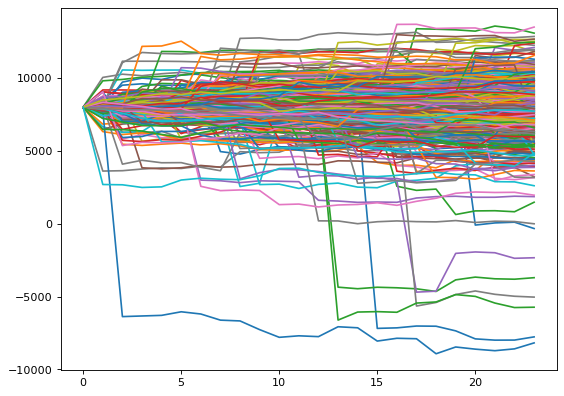

The portfolio would have been liquidated  11  times out of 1000


In [14]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

plt.plot(portfolio_paths)
plt.show()
df = liquidation_scenarios.apply(pd.Series.value_counts).T
print("The portfolio would have been liquidated ", df[False].count(), " times out of 1000")

In [73]:
print("The average portfolio value is: ", portfolio_paths.iloc[23].mean())
print("The median portfolio value is: ", portfolio_paths.iloc[23].median())
print("The maximum portfolio value is: ", portfolio_paths.iloc[23].max())
print("The minimum portfolio value is: ", portfolio_paths.iloc[23].min())

VaR = np.percentile(portfolio_paths.iloc[23], 5, axis=0)
ES = portfolio_paths.iloc[23][portfolio_paths.iloc[23] <= np.percentile(portfolio_paths.iloc[23], 5, axis=0)].mean()

print("\nPortfolio VaR: ", VaR, "\nA VaR of ", VaR, "  suggests that we are \
95% certain that our portfolio will be greater than ", VaR, 
     "\n in the next 24 hours")

print("\nExpected Shortfall: ", ES, "\nOn the condition that the 24h loss is greater than the 5th percentile" 
      " of the loss distribution, it is expected that \n the portfolio will be ", ES)

The average portfolio value is:  7779.475661232638
The median portfolio value is:  7998.923635638381
The maximum portfolio value is:  17040.978325986034
The minimum portfolio value is:  -15697.269919021826

Portfolio VaR:  4927.791820568504 
A VaR of  4927.791820568504   suggests that we are 95% certain that our portfolio will be greater than  4927.791820568504 
 in the next 24 hours

Expected Shortfall:  1639.520069091123 
On the condition that the 24h loss is greater than the 5th percentile of the loss distribution, it is expected that 
 the portfolio will be  1639.520069091123


In [42]:
np.percentile(portfolio_paths.iloc[23], 5, axis=0)

4927.791820568504

Text(0.5, 6.79999999999999, 'Portfolio Value')

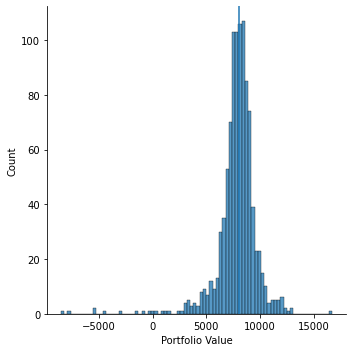

In [8]:
sns.displot(portfolio_paths.iloc[23])
plt.axvline(x=portfolio_paths.iloc[23].median())
plt.xlabel('Portfolio Value')

# Monte Carlo Simulation

In [9]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [10]:
correlations = result.corr(method='kendall') 
correlations

,returns_btc,returns_eth,returns_avax
returns_btc,1.000000,0.628845,0.296755
returns_eth,0.628845,1.000000,0.325476
returns_avax,0.296755,0.325476,1.000000


In [11]:
random_vals = multivariate_normal(cov=correlations).rvs(24)
copula = norm.cdf(random_vals)
print(copula.shape)
copula

(24, 3)


array([[0.8745467 , 0.8718216 , 0.29463386],
       [0.1431082 , 0.14204129, 0.33795999],
       [0.68200781, 0.41019104, 0.47529229],
       [0.18559957, 0.42202397, 0.05683012],
       [0.61252215, 0.4031239 , 0.28097567],
       [0.77939808, 0.52813868, 0.80083246],
       [0.9244255 , 0.9580551 , 0.5348669 ],
       [0.62749337, 0.31880557, 0.48113645],
       [0.92060841, 0.67431207, 0.87266754],
       [0.78818562, 0.59106414, 0.78674002],
       [0.18010436, 0.63436037, 0.32331315],
       [0.28867648, 0.27579783, 0.79184878],
       [0.58434561, 0.85336977, 0.0456162 ],
       [0.76183994, 0.93982814, 0.45646697],
       [0.52413178, 0.41561073, 0.42881328],
       [0.57261862, 0.53025049, 0.85089378],
       [0.92979615, 0.85688307, 0.83691351],
       [0.50778144, 0.33428234, 0.82240324],
       [0.87310307, 0.99150189, 0.73184063],
       [0.22068527, 0.41440229, 0.36388417],
       [0.86490814, 0.86552825, 0.79629915],
       [0.09565658, 0.18141841, 0.50113278],
       [0.

<AxesSubplot:>

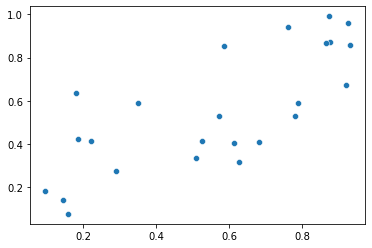

In [12]:
sns.scatterplot(x=copula[:, 0], y=copula[:, 1])

In [13]:
distribution_btc = norm(result['returns_btc'].mean(), result['returns_btc'].std())
distribution_eth = norm(result['returns_eth'].mean(), result['returns_eth'].std())
distribution_avax = norm(result['returns_avax'].mean(), result['returns_avax'].std())

btc_distribution = distribution_btc.ppf(copula[:, 0])
eth_distribution = distribution_eth.ppf(copula[:, 1])
avax_distribution = distribution_avax.ppf(copula[:, 2])

In [14]:
portfolio_paths = pd.DataFrame()
liquidation_scenarios = pd.DataFrame()

for x in range(0,10000):
    
    random_vals = multivariate_normal(cov=correlations).rvs(24)
    copula = norm.cdf(random_vals)
    
    btc_distribution = distribution_btc.ppf(copula[:, 0])
    eth_distribution = distribution_eth.ppf(copula[:, 1])
    avax_distribution = distribution_avax.ppf(copula[:, 2])
    pct_paths = np.stack((btc_distribution, eth_distribution, avax_distribution), axis=1)
    
    price_paths = np.full((hours, 3), float(1))
    price_paths[0] = [btc_start_price, eth_start_price, avax_start_price]

    
    for t in range(1, hours):
        price_paths[t] = np.array(price_paths[t-1]*(1 + pct_paths[t-1]), dtype=float)
        price_paths

    #Calculate Maintenance Margin
    maintenance_margin = price_paths * np.array([
        abs(btc_position), abs(eth_position), abs(avax_position)]) * np.array([btc_maintenence_margin, 
                                                                               eth_maintenence_margin, avax_maintenence_margin])
    maintenance_margin = np.sum(maintenance_margin, axis=1)
    maintenance_margin

    #Calculate Total Account Value
    Total_Account_Value = Initial_USDC + np.sum((price_paths - price_paths[0]) * np.array([btc_position, eth_position, 
                                                                                           avax_position]), axis=1)
    Total_Account_Value

    portfolio_paths = pd.concat([portfolio_paths, pd.DataFrame(Total_Account_Value)], axis=1)
    liquidation_scenarios = pd.concat([liquidation_scenarios, pd.DataFrame(Total_Account_Value > maintenance_margin)], axis=1)

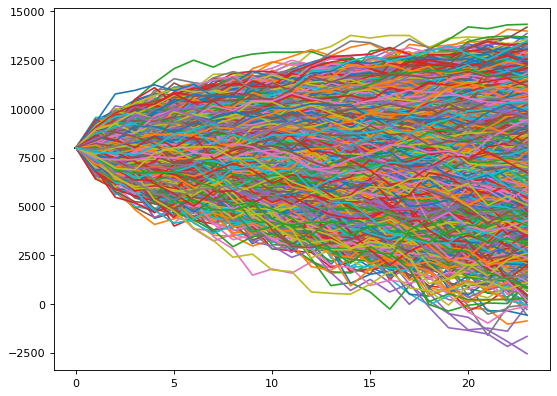

The portfolio would have been liquidated  111  times out of 10000


In [29]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

plt.plot(portfolio_paths)
plt.show()
df = liquidation_scenarios.apply(pd.Series.value_counts).T
print("The portfolio would have been liquidated ", df[False].count(), " times out of 10000")